In [59]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [45]:
# important paths and file names

BIKE_DATA_PATH = "/media/mircea/CEF1-30A0/data/"
MAIN_DATA_FILE_NAME = "_speed_acc.txt"

TRIP_SAVE_LOCATION = "/home/mircea/.bike-sys/"
CSV_HEAD_DATA_FILE = "velocity, delta V\n" 

DEFAULT_TRIP_NAME = "trip.txt"

In [44]:
# run to split the collected data into trips
#   (data is stored in equally sized chunks)

allFiles = os.listdir(BIKE_DATA_PATH)
dataFiles = [file for file in allFiles if MAIN_DATA_FILE_NAME in file]
dataFiles.sort()
print(dataFiles)

numberOfSavedTrips = 0

def findNumberOfSavedTrips():
    tripFiles = os.listdir(TRIP_SAVE_LOCATION)
    return len(tripFiles)

tripIdx = findNumberOfSavedTrips() - 1 # i do  ++ every time i find the csv header
currentTripName = str(tripIdx) + "_" + DEFAULT_TRIP_NAME

for dataFileName in dataFiles:
    with open(BIKE_DATA_PATH + dataFileName, 'r') as dataFile:
        for line in dataFile:
            if(line == CSV_HEAD_DATA_FILE):
                tripIdx += 1
                currentTripName = str(tripIdx) + "_" + DEFAULT_TRIP_NAME
            with open(TRIP_SAVE_LOCATION + currentTripName, 'a') as newTripFile:
                    newTripFile.write(line)

for dataFileName in dataFiles:
    os.remove(BIKE_DATA_PATH + dataFileName)


[]


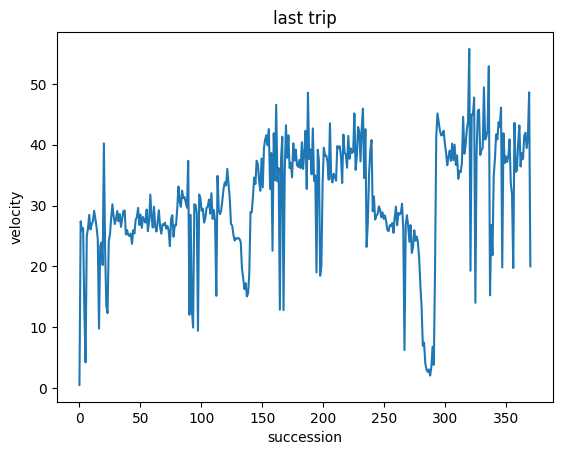

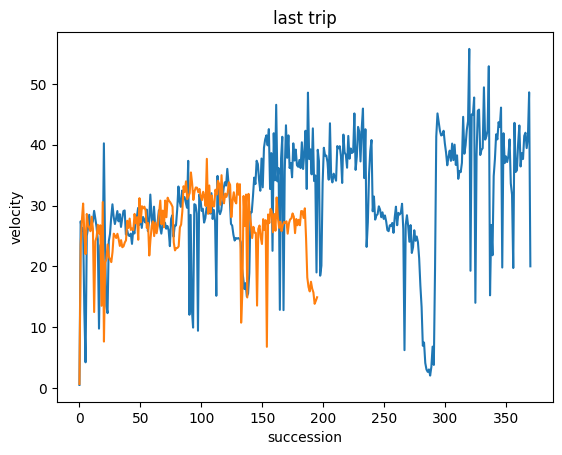

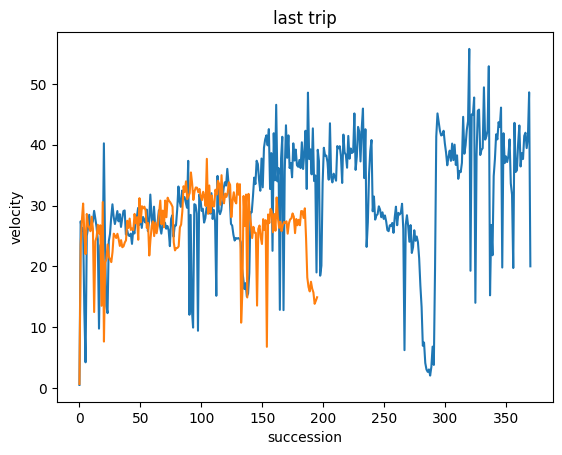

In [82]:
# run this to plot:
#   * the latest trip speed evolution
#   * the last 2 trips overlapped (to the destination and on the way back)
#   * past 10 trips overlapped (maybe spot a trend)

tripFiles = os.listdir(TRIP_SAVE_LOCATION)
tripFiles.sort(reverse=True)

plotsToOverlap = 1
for tripFileName in tripFiles[:plotsToOverlap]:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    plt.plot(np.linspace(0, len(tripCsv["velocity"]), len(tripCsv["velocity"])), tripCsv["velocity"])
plt.xlabel("succession")
plt.ylabel("velocity")
plt.title("last trip")
plt.show()

plotsToOverlap = 2
plt.title("last 2 trips")
for tripFileName in tripFiles[:plotsToOverlap]:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    plt.plot(np.linspace(0, len(tripCsv["velocity"]), len(tripCsv["velocity"])), tripCsv["velocity"])
plt.xlabel("succession")
plt.ylabel("velocity")
plt.title("last trip")
plt.show()


plotsToOverlap = 10
plt.title("last 10 trips")
for tripFileName in tripFiles[:plotsToOverlap]:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    plt.plot(np.linspace(0, len(tripCsv["velocity"]), len(tripCsv["velocity"])), tripCsv["velocity"])
plt.xlabel("succession")
plt.ylabel("velocity")
plt.title("last trip")
plt.show()


Index(['velocity', ' delta V'], dtype='object')


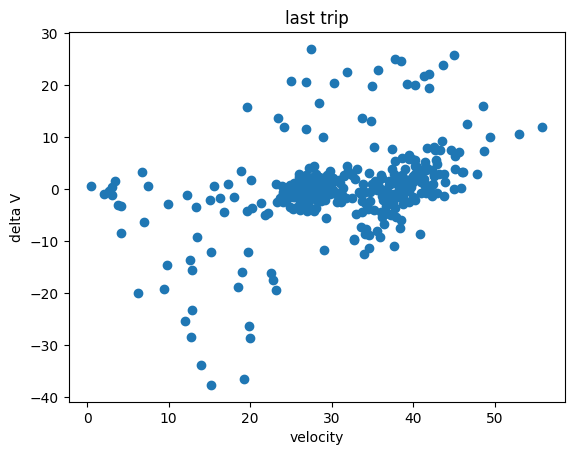

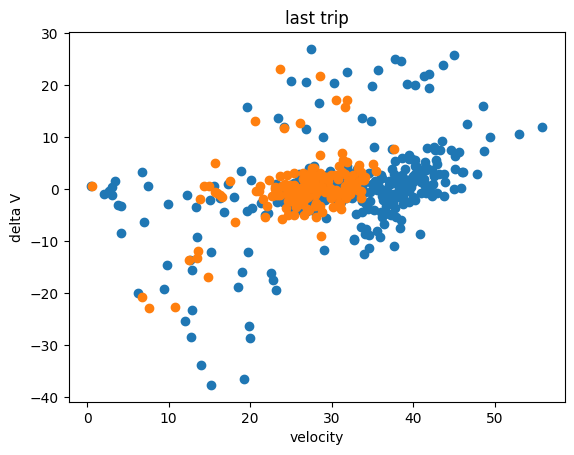

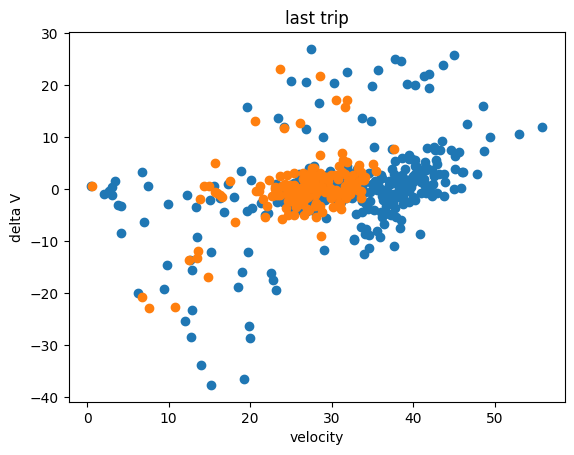

In [102]:
# run this to plot:
#   * the latest trip 
#   * the last 2 trips overlapped (to the destination and on the way back)
#   * past 10 trips overlapped (maybe spot a trend)

tripFiles = os.listdir(TRIP_SAVE_LOCATION)
tripFiles.sort(reverse=True)

plotsToOverlap = 1
for tripFileName in tripFiles[:plotsToOverlap]:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    print(tripCsv.columns)
    plt.scatter(tripCsv["velocity"], tripCsv[" delta V"])
plt.xlabel("velocity")
plt.ylabel("delta V")
plt.title("last trip")
plt.show()

plotsToOverlap = 2
plt.title("last 2 trips")
for tripFileName in tripFiles[:plotsToOverlap]:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    plt.scatter(tripCsv["velocity"], tripCsv[" delta V"])
plt.xlabel("velocity")
plt.ylabel("delta V")
plt.title("last trip")
plt.show()


plotsToOverlap = 10
plt.title("last 10 trips")
for tripFileName in tripFiles[:plotsToOverlap]:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    plt.scatter(tripCsv["velocity"], tripCsv[" delta V"])
plt.xlabel("velocity")
plt.ylabel("delta V")
plt.title("last trip")
plt.show()
